## 개와 고양이 분류기

<hr/>

<br/>

### VGGNet

In [1]:
# 런타임 유형 GPU 모드로 변경
!pip install torch torchvision

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
batch_size= 1
learning_rate = 0.0002
num_epoch = 10

In [4]:
# 라벨(혹은 클래스) 별로 폴더가 저장되어 있는 루트 디렉토리를 지정합니다.
train_img_dir = "./archive/dataset/training_set"
test_img_dir = "./archive/dataset/test_set"

# 해당 루트 디렉토리를 ImageFolder 함수에 전달합니다.
# 이때 이미지들에 대한 변형도 같이 전달해줍니다.
train_img_data = dset.ImageFolder(train_img_dir, transforms.Compose([
                                      transforms.Resize(256),                   # 이미지 크기를 256x256으로 바꿔줍니다.
                                      transforms.RandomResizedCrop(224),        # 256x256 이미지의 랜덤한 위치에서 224x224 크기만큼 샘플링 합니다.
                                      transforms.RandomHorizontalFlip(),        # 랜덤한 확률로 이미지를 좌우반전 합니다.
                                      transforms.ToTensor(),                    # 이미지 데이터를 텐서로 변형합니다.
            ]))

test_img_data = dset.ImageFolder(test_img_dir, transforms.Compose([
                                      transforms.Resize(256),                   # 이미지 크기를 256x256으로 바꿔줍니다.
                                      transforms.RandomResizedCrop(224),        # 256x256 이미지의 랜덤한 위치에서 224x224 크기만큼 샘플링 합니다.
                                      transforms.RandomHorizontalFlip(),        # 랜덤한 확률로 이미지를 좌우반전 합니다.
                                      transforms.ToTensor(),                    # 이미지 데이터를 텐서로 변형합니다.
            ]))

train_loader = data.DataLoader(train_img_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)

test_loader = data.DataLoader(test_img_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)


In [5]:
# 컨볼루션 연산이 2번 연속하는 경우
# 컨볼루션-활성화함수-컨볼루션-활성화함수-풀링
def conv_2_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

  
# 컨볼루션 연산이 3번 연속하는 경우
# 컨볼루션-활성화함수-컨볼루션-활성화함수-컨볼루션-활성화함수-풀링
def conv_3_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

### VGG Model

In [6]:
# 위에서 정의한 블록들을 이용해 VGG 네트워크를 만들어보겠습니다.
# 필터의 개수가 2의 n승의 값을 가지기 때문에 base_dim이란 변수를 추가해서 단순화 했습니다.
# 현재 dog, cat 두 가지 클래스를 구분하려고 하기 때문에 num_classes=2로 설정했습니다.

class VGG(nn.Module):
    def __init__(self, base_dim, num_classes=2):
        super(VGG, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim),
            conv_2_block(base_dim,2*base_dim),
            conv_3_block(2*base_dim,4*base_dim),
            conv_3_block(4*base_dim,8*base_dim),
            conv_3_block(8*base_dim,8*base_dim),            
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(8*base_dim * 7 * 7, 100),
            nn.ReLU(True),                                                      # True 는 inplace 연산을 하겠다는 의미를 가집니다. inplace 연산은 결과값을 새로운 변수에 값을 저장하는 대신 기존의 데이터를 대체하는것을 의미합니다.
            #nn.Dropout(),
            nn.Linear(100, 20),
            nn.ReLU(True),
            #nn.Dropout(),
            nn.Linear(20, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)                                               # x.size(0)를 batch size로 바꿔도 같은 값입니다.
        x = self.fc_layer(x)
        return x

### Optimizer & Loss

In [7]:
# gpu가 사용 가능한 경우에는 device를 0번 gpu로 설정하고 불가능하면 cpu로 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 앞서 정의한대로 vGG 클래스를 인스턴스화 하고 지정한 장치에 올립니다.
model = VGG(base_dim=16).to(device)

# 손실함수 및 최적화함수를 설정합니다.
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 모델 자녀 노드의 이름과 모듈을 출력합니다.
for i in model.named_children():
    print(i)

cuda:0
('feature', Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Seque

In [8]:
images, labels = next(iter(train_loader))
images.shape

torch.Size([1, 3, 224, 224])

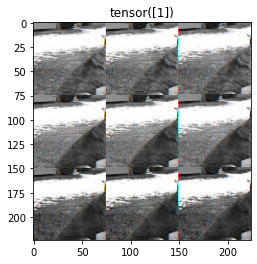

In [9]:
plt.title(labels)
plt.imshow(images.reshape(224, 224, 3), cmap='gist_yarg')
plt.show()

### 학습 Train

In [10]:
loss_arr = []
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
    print(loss)
    loss_arr.append(loss.cpu().detach().numpy())

tensor(0.6510, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6785, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6976, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6831, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6902, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6951, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7061, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7045, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6961, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward0>)


### 학습 그래프 및 테스트

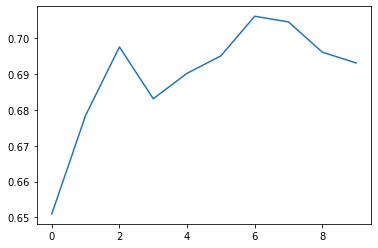

In [11]:
import matplotlib.pyplot as plt

plt.plot(loss_arr)
plt.show()

In [12]:
correct = 0
total = 0

with torch.no_grad():
    for image, label in test_loader:
        x = image.to(device)
        y_ = label.to(device)

        output = model.forward(x)
        _, output_index = torch.max(output, 1)

        total += label.size(0)
        correct += (output_index == y_).sum().float()

    print("Accuracy of Test Data: {} %".format(100*correct/total))

print(total)
print(correct)

Accuracy of Test Data: 50.000003814697266 %
2000
tensor(1000., device='cuda:0')
